In [6]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import collections
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [7]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,3) #Cart를 왼쪽, 오른쪽 또는 그대로 있는다. output 3개
     
    #nforward 방향 network 구성
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #왼쪽, 오른쪽 미는 액션에 대한 Q 값
        return x
    
    def sample_action(self, obs, epsilon): #option 함수인데, 액션을 고르는 Function 
        out = self.forward(obs) #state 를 NN 에 입력
        rv = random.random() #epsilon Greedy 를 하고 있어서, Random value 생성
        
        if rv<epsilon:
            return random.randint(0,2) #0, 1, 2 액션 중에 random 하게 return
        else:
            return out.argmax().item() # Q 값이 큰 액션을 return


In [8]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=50000) #deque 를 이용해서 replaybuffer 생성
    
    def size(self):
        return len(self.buffer)
    
    def put(self, transition):
        self.buffer.append(transition) #buffer에 넣는다
        
    def sample(self,n):
        mini_batch = random.sample(self.buffer,n) #buffer에서 n 개의 sample 을 꺼내온다
        
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [],[],[],[],[]  #transition 의 s, a, r 끼리 리스트 만들기
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)  #s는 벡터
            a_lst.append([a]) #a는 상수값
            r_lst.append([r]) #r도 상수값
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
     
        #tensor 형태로 바꿔서 전달
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)
    
            

In [9]:
def train(q, q_target, memory, optimizer):
    
    for i in range(15):
        s, a, r, s_prime, done_mask = memory.sample(32) #s 는 4차원 벡터이고, 32개 호출했으니 32X4 벡터
        
        q_out = q(s) #q는 main에서 DQN, DQN을 호출하면 Forward를 호출하도록 torch.nn.Moduel에서 정의되어 있음
        q_a = q_out.gather(1,a) #32개의 action vector
            #[[0.4,0.6],[0.3,0.7],[0.9,0.1]] 일때 a = 0,1,0 이면 q_a =[0.4,0.7,0.9]
        
        #argmax_Q = q(s_prime).max(1)[1].unsqueeze(1) #loss function 계산하는 수식
        #max_q_prime = q_target(s_prime).gather(1,argmax_Q)#DQN 교제 17page 수식
        
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        #gamma=0.05
        target = r + 0.05*max_q_prime * done_mask
        
        #loss = F.mse_loss(q_a, target)
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

Episode :1, Score : 1870.0, Buffer : 400, Epsilon : 8.0%, Success_count : 0
Episode :2, Score : 900.0, Buffer : 600, Epsilon : 8.0%, Success_count : 0
Episode :3, Score : 940.0, Buffer : 800, Epsilon : 8.0%, Success_count : 0
Episode :4, Score : 900.0, Buffer : 1000, Epsilon : 8.0%, Success_count : 0
Episode :5, Score : 830.0, Buffer : 1200, Epsilon : 8.0%, Success_count : 0
Episode :6, Score : 900.0, Buffer : 1400, Epsilon : 8.0%, Success_count : 0
Episode :7, Score : 940.0, Buffer : 1600, Epsilon : 8.0%, Success_count : 0
Episode :8, Score : 940.0, Buffer : 1800, Epsilon : 8.0%, Success_count : 0
Episode :9, Score : 960.0, Buffer : 2000, Epsilon : 8.0%, Success_count : 0
Episode :10, Score : 950.0, Buffer : 2200, Epsilon : 8.0%, Success_count : 0
Episode :11, Score : 930.0, Buffer : 2400, Epsilon : 7.9%, Success_count : 0
Episode :12, Score : 700.0, Buffer : 2600, Epsilon : 7.9%, Success_count : 0
Episode :13, Score : 950.0, Buffer : 2800, Epsilon : 7.9%, Success_count : 0
Episode :1

Episode :109, Score : 870.0, Buffer : 22000, Epsilon : 7.5%, Success_count : 0
Episode :110, Score : 800.0, Buffer : 22200, Epsilon : 7.4%, Success_count : 0
Episode :111, Score : 860.0, Buffer : 22400, Epsilon : 7.4%, Success_count : 0
Episode :112, Score : 12400.0, Buffer : 22600, Epsilon : 7.4%, Success_count : 59
Episode :113, Score : 940.0, Buffer : 22800, Epsilon : 7.4%, Success_count : 0
Episode :114, Score : 880.0, Buffer : 23000, Epsilon : 7.4%, Success_count : 0
Episode :115, Score : 910.0, Buffer : 23200, Epsilon : 7.4%, Success_count : 0
Episode :116, Score : 920.0, Buffer : 23400, Epsilon : 7.4%, Success_count : 0
Episode :117, Score : 930.0, Buffer : 23600, Epsilon : 7.4%, Success_count : 0
Episode :118, Score : 890.0, Buffer : 23800, Epsilon : 7.4%, Success_count : 0
Episode :119, Score : 4020.0, Buffer : 24000, Epsilon : 7.4%, Success_count : 16
Episode :120, Score : 970.0, Buffer : 24200, Epsilon : 7.4%, Success_count : 0
Episode :121, Score : 11960.0, Buffer : 24400, 

Episode :213, Score : 700.0, Buffer : 42800, Epsilon : 6.9%, Success_count : 0
Episode :214, Score : 8510.0, Buffer : 43000, Epsilon : 6.9%, Success_count : 39
Episode :215, Score : 700.0, Buffer : 43200, Epsilon : 6.9%, Success_count : 0
Episode :216, Score : 980.0, Buffer : 43400, Epsilon : 6.9%, Success_count : 0
Episode :217, Score : 9490.0, Buffer : 43600, Epsilon : 6.9%, Success_count : 44
Episode :218, Score : 930.0, Buffer : 43800, Epsilon : 6.9%, Success_count : 0
Episode :219, Score : 8150.0, Buffer : 44000, Epsilon : 6.9%, Success_count : 37
Episode :220, Score : 870.0, Buffer : 44200, Epsilon : 6.9%, Success_count : 0
Episode :221, Score : 580.0, Buffer : 44400, Epsilon : 6.9%, Success_count : 0
Episode :222, Score : 920.0, Buffer : 44600, Epsilon : 6.9%, Success_count : 0
Episode :223, Score : 10450.0, Buffer : 44800, Epsilon : 6.9%, Success_count : 49
Episode :224, Score : 650.0, Buffer : 45000, Epsilon : 6.9%, Success_count : 0
Episode :225, Score : 900.0, Buffer : 45200

Episode :317, Score : 8230.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 37
Episode :318, Score : 6690.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 30
Episode :319, Score : 850.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :320, Score : 970.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :321, Score : 8470.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 39
Episode :322, Score : 930.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :323, Score : 970.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :324, Score : 6120.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 27
Episode :325, Score : 10250.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 48
Episode :326, Score : 820.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :327, Score : 4370.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 18
Episode :328, Score : 910.0, Buffer : 50000, Epsilon : 6.4%, Success_count : 0
Episode :329, Score : 11880.0, Buffer :

Episode :420, Score : 16800.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 82
Episode :421, Score : 9270.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 43
Episode :422, Score : 8100.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 37
Episode :423, Score : 6140.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 27
Episode :424, Score : 6730.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 30
Episode :425, Score : 910.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 0
Episode :426, Score : 830.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 0
Episode :427, Score : 7470.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 34
Episode :428, Score : 8050.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 37
Episode :429, Score : 9670.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 45
Episode :430, Score : 6920.0, Buffer : 50000, Epsilon : 5.9%, Success_count : 31
Episode :431, Score : 8690.0, Buffer : 50000, Epsilon : 5.8%, Success_count : 40
Episode :432, Score : 9240.0, B

Episode :523, Score : 8900.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 41
Episode :524, Score : 10110.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 47
Episode :525, Score : 7560.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 34
Episode :526, Score : 7850.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 36
Episode :527, Score : 4750.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 20
Episode :528, Score : 7090.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 32
Episode :529, Score : 7660.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 35
Episode :530, Score : 7680.0, Buffer : 50000, Epsilon : 5.4%, Success_count : 35
Episode :531, Score : 920.0, Buffer : 50000, Epsilon : 5.3%, Success_count : 0
Episode :532, Score : 8430.0, Buffer : 50000, Epsilon : 5.3%, Success_count : 39
Episode :533, Score : 4420.0, Buffer : 50000, Epsilon : 5.3%, Success_count : 18
Episode :534, Score : 8910.0, Buffer : 50000, Epsilon : 5.3%, Success_count : 41
Episode :535, Score : 7720.0,

Episode :625, Score : 5760.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 25
Episode :626, Score : 6760.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 30
Episode :627, Score : 4560.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 19
Episode :628, Score : 870.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 0
Episode :629, Score : 900.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 0
Episode :630, Score : 8150.0, Buffer : 50000, Epsilon : 4.9%, Success_count : 37
Episode :631, Score : 8750.0, Buffer : 50000, Epsilon : 4.8%, Success_count : 40
Episode :632, Score : 5960.0, Buffer : 50000, Epsilon : 4.8%, Success_count : 26
Episode :633, Score : 7980.0, Buffer : 50000, Epsilon : 4.8%, Success_count : 36
Episode :634, Score : 6100.0, Buffer : 50000, Epsilon : 4.8%, Success_count : 27
Episode :635, Score : 6590.0, Buffer : 50000, Epsilon : 4.8%, Success_count : 29
Episode :636, Score : 760.0, Buffer : 50000, Epsilon : 4.8%, Success_count : 0
Episode :637, Score : 2540.0, Buff

Episode :727, Score : 8570.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 39
Episode :728, Score : 9720.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 45
Episode :729, Score : 21890.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 107
Episode :730, Score : 920.0, Buffer : 50000, Epsilon : 4.4%, Success_count : 0
Episode :731, Score : 9110.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 42
Episode :732, Score : 8670.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 40
Episode :733, Score : 890.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 0
Episode :734, Score : 9110.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 42
Episode :735, Score : 9110.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 42
Episode :736, Score : 8450.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 38
Episode :737, Score : 22060.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 108
Episode :738, Score : 20230.0, Buffer : 50000, Epsilon : 4.3%, Success_count : 98
Episode :739, Score : 5930.

Episode :829, Score : 860.0, Buffer : 50000, Epsilon : 3.9%, Success_count : 0
Episode :830, Score : 820.0, Buffer : 50000, Epsilon : 3.9%, Success_count : 0
Episode :831, Score : 5960.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 26
Episode :832, Score : 9650.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 45
Episode :833, Score : 930.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 0
Episode :834, Score : 1010.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 0
Episode :835, Score : 4380.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 18
Episode :836, Score : 730.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 0
Episode :837, Score : 940.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 0
Episode :838, Score : 9750.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 45
Episode :839, Score : 9110.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 42
Episode :840, Score : 11450.0, Buffer : 50000, Epsilon : 3.8%, Success_count : 54
Episode :841, Score : 6470.0, Buffer :

Episode :931, Score : 9700.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 45
Episode :932, Score : 920.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 0
Episode :933, Score : 980.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 0
Episode :934, Score : 7760.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 35
Episode :935, Score : 8150.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 37
Episode :936, Score : 8290.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 38
Episode :937, Score : 11260.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 53
Episode :938, Score : 9300.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 43
Episode :939, Score : 9730.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 45
Episode :940, Score : 9090.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 42
Episode :941, Score : 6610.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 29
Episode :942, Score : 910.0, Buffer : 50000, Epsilon : 3.3%, Success_count : 0
Episode :943, Score : 8100.0, Buf

Episode :1033, Score : 8690.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 40
Episode :1034, Score : 950.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1035, Score : 930.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1036, Score : 6560.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 29
Episode :1037, Score : 820.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1038, Score : 7540.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 34
Episode :1039, Score : 6370.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 28
Episode :1040, Score : 760.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1041, Score : 990.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1042, Score : 870.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 0
Episode :1043, Score : 5110.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 22
Episode :1044, Score : 8360.0, Buffer : 50000, Epsilon : 2.8%, Success_count : 38
Episode :1045, Score : 930.0

Episode :1135, Score : 8380.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 38
Episode :1136, Score : 680.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1137, Score : 980.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1138, Score : 6680.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 30
Episode :1139, Score : 4590.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 19
Episode :1140, Score : 670.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1141, Score : 6780.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 30
Episode :1142, Score : 840.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1143, Score : 900.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 0
Episode :1144, Score : 9080.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 42
Episode :1145, Score : 9020.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 41
Episode :1146, Score : 8180.0, Buffer : 50000, Epsilon : 2.3%, Success_count : 37
Episode :1147, Score : 830

Episode :1237, Score : 930.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1238, Score : 1030.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1239, Score : 6140.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 27
Episode :1240, Score : 950.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1241, Score : 890.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1242, Score : 1430.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1243, Score : 840.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 0
Episode :1244, Score : 4330.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 17
Episode :1245, Score : 6800.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 30
Episode :1246, Score : 7370.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 33
Episode :1247, Score : 6790.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 30
Episode :1248, Score : 10480.0, Buffer : 50000, Epsilon : 1.8%, Success_count : 49
Episode :1249, Score : 55

Episode :1339, Score : 1050.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1340, Score : 960.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1341, Score : 4540.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 18
Episode :1342, Score : 980.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1343, Score : 4680.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 19
Episode :1344, Score : 880.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1345, Score : 810.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1346, Score : 880.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1347, Score : 940.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 0
Episode :1348, Score : 5800.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 25
Episode :1349, Score : 6680.0, Buffer : 50000, Epsilon : 1.3%, Success_count : 29
Episode :1350, Score : 1000.0, Buffer : 50000, Epsilon : 1.2%, Success_count : 0
Episode :1351, Score : 6640.0,

Episode :1441, Score : 880.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1442, Score : 6800.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 30
Episode :1443, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1444, Score : 5140.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 21
Episode :1445, Score : 980.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1446, Score : 880.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1447, Score : 850.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1448, Score : 1000.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1449, Score : 1010.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1450, Score : 930.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1451, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1452, Score : 1060.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1453, Score : 950.0, Buf

Episode :1543, Score : 820.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1544, Score : 1150.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1545, Score : 990.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1546, Score : 5460.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 23
Episode :1547, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1548, Score : 910.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1549, Score : 860.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1550, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1551, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1552, Score : 980.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1553, Score : 1420.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1554, Score : 3070.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 11
Episode :1555, Score : 970.0, Buff

Episode :1645, Score : 880.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1646, Score : 900.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1647, Score : 760.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1648, Score : 1100.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1649, Score : 2090.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 5
Episode :1650, Score : 990.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1651, Score : 870.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1652, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1653, Score : 690.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1654, Score : 1000.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1655, Score : 970.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1656, Score : 820.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1657, Score : 1040.0, Buffer

Episode :1747, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1748, Score : 980.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1749, Score : 930.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1750, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1751, Score : 790.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1752, Score : 890.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1753, Score : 990.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1754, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1755, Score : 970.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1756, Score : 970.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1757, Score : 900.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1758, Score : 900.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1759, Score : 950.0, Buffer : 5

Episode :1850, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1851, Score : 990.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1852, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1853, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1854, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1855, Score : 960.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1856, Score : 980.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1857, Score : 970.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1858, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1859, Score : 1200.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1860, Score : 950.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1861, Score : 1640.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1862, Score : 1030.0, Buffer 

Episode :1953, Score : 900.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1954, Score : 1270.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1955, Score : 920.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1956, Score : 1110.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1957, Score : 970.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1958, Score : 980.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1959, Score : 6300.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 27
Episode :1960, Score : 930.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1961, Score : 1000.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1962, Score : 940.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1963, Score : 4590.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 18
Episode :1964, Score : 1040.0, Buffer : 50000, Epsilon : 1.0%, Success_count : 0
Episode :1965, Score : 1040.0, B

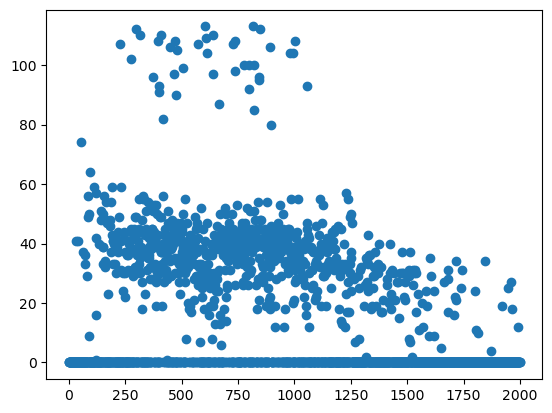

In [10]:
def main():
    #env = gym.make('MountainCar-v0', render_mode="human")
    env = gym.make('MountainCar-v0')
    q = DQN()
    q_target = DQN()
    q_target.load_state_dict(q.state_dict()) #q 의 파라미터를 q_target에 copy
    
    memory = ReplayBuffer()
    
    optimizer = optim.Adam(q.parameters(), lr=0.0005)  #parameter optimize, learnning rate 는 0.0005
    
    score = 0.0
    max_position = -0.4
    success = 0    
    positions = np.ndarray([0,2])  
    success_list = []
    epi_list = []
        
    for n_epi in range(2000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #
        
        s, _ = env.reset()
        done = False
        
        epi_cnt = 0
        
        while not done: #episode 를 진행하면서 transition 을 replay buffer에 넣고 있는 반복문
            a = q.sample_action(torch.from_numpy(s), epsilon) #sample_action(self, obs, epsilon) 인데, self 빼고 인자 2개 주고 호출, 액션을 하나 고름
            #s_prime, r, terminated, truncated, info = env.step(a)
            s_prime, r, info, done, _ = env.step(a)            
            done_mask = 0.0 if done else 1.0 #0이면 끝났다는 것, 1이면 안끝났다는 것
            epi_cnt +=1
            #print("epi_cnt=",epi_cnt,"  ",s_prime,"  ", r,"  ",done,"  ",info)
                        
            if s_prime[0] > max_position:
                max_position = s_prime[0]
            
            positions = np.append(positions, [[n_epi, max_position]], axis=0)
            
            #Positon에 따라 rewqrd 부여
            #r = float(((s_prime[0])+0.5)*20) 
            #r = float(abs(s_prime[0])+5)
            
            #왼쪽에 있을때 다음 state가 왼쪽이면 추가 reward, 오른쪽일때도 동일
            if s_prime[0] > s[0] and s_prime[0]>0 and s[0]>0:
                r += 10
            elif s_prime[0] < s[0] and s_prime[0]<=0 and s[0]<=0:
                r +=10
            
            if s_prime[0] >= 0.5: #flag 위치가 0.5
                success += 1 #flag에 닿으면 성공
                r += 200 #성공하면 리워드 20을 받는다.
            #else:
            #    r -= 1
            
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime # 다음 state로 간다
            
            score += r
            
            #print("score = ",score, " epi = ",n_epi, " s_prime[1]= ",s_prime[1])
            
            if done:                 
                max_position=-0.4                
                break
        
        if memory.size() > 2000: #buffer size가 2000 이상일때 train 한다. 너무 적을때 하면 효과가 떨어짐
            train(q,q_target, memory, optimizer)
        
        if (n_epi != 0):
            q_target.load_state_dict(q.state_dict())
            print("Episode :{}, Score : {:.1f}, Buffer : {}, Epsilon : {:.1f}%, Success_count : {}".format(n_epi, score, memory.size(), epsilon*100, success))
            
            success_list.append(success)
            epi_list.append(n_epi)
            
            score = 0.0
            success = 0
            
    env.close()
    
    print("Total Success Count = ", sum(success_list))
    
    #plt.plot(X=epi_list,y=success_list)
    plt.scatter(epi_list,success_list)
    plt.show()

if __name__ == '__main__':
    main()

In [11]:
os.getcwd()

'C:\\Users\\DKSYSTEMS'